In [3]:
from all_imports import *
import _modules 

from _modules.plotColors import *


participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])

# Convert datetime column to 'Asia/Singapore' timezone using tz_convert
participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['index_time'], format='mixed')
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_convert('Asia/Singapore')
print(participant_data_local_df['index_time'].dtype) 
display(participant_data_local_df['index_time']) 

#Cull data here by time per grouped id_participant for no duplicate index date 
# display(participant_data_local_df['c_total_valid_data'].describe())
# print(participant_data_local_df['c_total_valid_data'].dtypes)
participant_data_local_df = participant_data_local_df[participant_data_local_df['c_total_valid_data']]

#Cull data that is not from a run or from thermal history.
whitelistParticipants = ['esse00', 'esse01', 'esse03', 'esse04', 'esse05', 'esse06']
whitelistParticipantsRnd1 = ['esse00', 'esse09', 'esse10', 'esse08', 'esse11', 'esse02', 'esse14', 'esse07', 'esse13']

file_name: str = "_01-TimeSeriesData"
filepath_dir: str =os.path.join(r"C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report", file_name)

C:\Users\gottk\AppData\Local\Temp\ipykernel_27804\3028150708.py:7: DtypeWarning: Columns (5,6,7,9,11,13,17,18,19,21,25,26,46,47,49,50,79,80,82,83,97) have mixed types. Specify dtype option on import or set low_memory=False.
  participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])


datetime64[ns, Asia/Singapore]


0               2023-11-22 22:41:56+08:00
1               2023-11-22 22:42:31+08:00
2               2023-11-22 22:43:34+08:00
3               2023-11-22 22:44:14+08:00
4               2023-11-22 22:48:21+08:00
                       ...               
497795          2024-04-09 16:55:00+08:00
497796   2024-04-09 16:55:01.194000+08:00
497797   2024-04-09 16:55:24.390000+08:00
497798   2024-04-09 17:00:04.049000+08:00
497799   2024-04-09 17:00:07.878000+08:00
Name: index_time, Length: 497800, dtype: datetime64[ns, Asia/Singapore]

#### Display of Average Data per Run by participants

AveParticipantData_df

In [ ]:
# Assuming you've already loaded participant_data_local_df
df = participant_data_local_df[['index_time', 'id_participant', 'c_longitude', 'c_latitude', 
                                'c_thermalhistory', 'run_valid', 'Scoria_horizontal_accuracy', 
                                'ws_location_accuracy_horizontal']].copy()

df['c_horizontal_accuracy'] = df['Scoria_horizontal_accuracy'] + df['ws_location_accuracy_horizontal']
df.to_csv('df.csv')  # Save a copy of df if needed

df = df.dropna(subset=['c_longitude'])
df = df.sort_values('index_time')
df = df[df['c_thermalhistory'] == False]

grouped_df = df.groupby(['id_participant'])

# Compute time differences
computed_df = grouped_df['index_time'].diff().dt.total_seconds().to_frame(name='c_time_difference_between_locations')
computed_df['id_participant'] = df['id_participant']  # Add id_participant back to computed_df
computed_df_with = computed_df.copy()

computed_df.dropna(subset=['c_time_difference_between_locations'], inplace=True)

computed_df.to_csv('test.csv')  # Save computed_df if needed
display(computed_df.describe())

# Filter based on time difference criteria
filtered_computed_df = computed_df[computed_df['c_time_difference_between_locations'] <= 1800]
filtered_computed_df['c_time_difference_between_locations'] /= 60.0  # Convert seconds to minutes

# Create boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_computed_df, x='id_participant', y='c_time_difference_between_locations')
plt.title('Boxplot of Time Differences Between Locations by Participant (Thermal History = False)')
plt.xlabel('Participant ID')
plt.ylabel('Time Difference Between Locations')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()


filtered_computed_df_with = computed_df_with[computed_df_with['c_time_difference_between_locations'] <= 1800]
filtered_computed_df_with['c_time_difference_between_locations'] /= 60.0  # Convert seconds to minutes

# Create boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_computed_df_with, x='id_participant', y='c_time_difference_between_locations')
plt.title('Boxplot of Time Differences Between Locations by Participant (Thermal History = True)')
plt.xlabel('Participant ID')
plt.ylabel('Time Difference Between Locations')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()



In [ ]:
# ------> #INFO DISTANCE BETWEEN LOCATION POINTS
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
from haversine import haversine, Unit

# Function to calculate Haversine distance between two points
def calculate_haversine(lat1, lon1, lat2, lon2):
    return haversine((lat1, lon1), (lat2, lon2), unit=Unit.KILOMETERS)

# Create a copy of the specified columns
df = participant_data_local_df[['index_time', 'id_participant', 'c_longitude', 'c_latitude', 'c_thermalhistory', 'run_valid']].copy()

# Drop rows where 'c_longitude' or 'c_latitude' is NaN
df = df.dropna(subset=['c_longitude', 'c_latitude'])

# Sort the DataFrame by 'index_time' to ensure correct distance calculation
df = df.sort_values('index_time')

# Filter the DataFrame to include only rows where 'c_thermalhistory' is False
df = df[df['c_thermalhistory'] == False]

# Calculate distances between consecutive points for each participant
df['c_latitude_shift'] = df.groupby('id_participant')['c_latitude'].shift(-1)
df['c_longitude_shift'] = df.groupby('id_participant')['c_longitude'].shift(-1)

df['distance_between_points'] = df.apply(lambda row: calculate_haversine(row['c_latitude'], row['c_longitude'],
                                                                            row['c_latitude_shift'], row['c_longitude_shift']), axis=1)

# Drop the last row for each participant since it has NaN for shifted values
df = df.dropna(subset=['distance_between_points'])

# Filter out values above a certain threshold in meters (e.g., 2000 meters)
filtered_df = df[df['distance_between_points'] <= 2000]


# Create a boxplot with 'id_participant' on the x-axis for filtered data
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_df, x='id_participant', y='distance_between_points')
plt.title('Boxplot of Distances Between Locations by Participant (Thermal History = False)')
plt.xlabel('Participant ID')
plt.ylabel('Distance Between Locations (km)')
plt.xticks(rotation=45)  # Rotate x labels if needed
plt.show()

In [ ]:
genColumns = ['id_participant']
physioColumns = ['ws_heart_rate', 'ts_heart_rate', 'ts_HRV', 'ws_HRV', 'ts_resting_heart_rate', 'ws_resting_heart_rate', 'ws_oxygen_saturation', 'ts_oxygen_saturation']
selColumns = genColumns + physioColumns
df = participant_data_local_df[selColumns].copy()

renaming = {'ws_heart_rate': 'ws_HR', 'ts_heart_rate': 'ts_HR',
            'ws_resting_heart_rate': 'ws_RHR', 'ts_resting_heart_rate': 'ts_RHR',
            'ws_oxygen_saturation': 'ws_OS', 'ts_oxygen_saturation': 'ts_OS'}
            # HRV does not need renaming

# Rename columns using rename() function
df.rename(columns=renaming, inplace=True)

#df = df[~df['id_participant'].isin(whitelistParticipants)]
grouped_df = df.groupby(['id_participant']).count()

display(grouped_df)

ESSE02_AveParticipantData_df = grouped_df.loc['esse02']
ESSE07_AveParticipantData_df = grouped_df.loc['esse07']
ESSE08_AveParticipantData_df = grouped_df.loc['esse08']
ESSE09_AveParticipantData_df = grouped_df.loc['esse09']
ESSE10_AveParticipantData_df = grouped_df.loc['esse10']
ESSE11_AveParticipantData_df = grouped_df.loc['esse11']
ESSE13_AveParticipantData_df = grouped_df.loc['esse13']
ESSE14_AveParticipantData_df = grouped_df.loc['esse14']

display(ESSE02_AveParticipantData_df)

data = 'PHYSIOLOGICAL'

title00 = 'TOTAL ' + data + ' FOR [esse02]' 
title01 = 'TOTAL ' + data + ' FOR [esse07]' 
title10 = 'TOTAL ' + data + ' FOR [esse08]' 
title11 = 'TOTAL ' + data + ' FOR [esse09]' 
title20 = 'TOTAL ' + data + ' FOR [esse10]' 
title21 = 'TOTAL ' + data + ' FOR [esse11]' 
title30 = 'TOTAL ' + data + ' FOR [esse13]' 
title31 = 'TOTAL ' + data + ' FOR [esse14]' 




subtitle1 = ('This is the subtitle, it is usually about 50 characters long and then \n'
                'a break in order to continue ')
xlabel1 = 'Participant Id' 
ylabel1 = 'Total Count of datapoints'
colors1 = ['#A9A9A9', '#ADD8E6', '#FFFF00', 'Green', 'Blue']
ymax1 = 1000

yticks = ([0, 200, 400, 600, 800, 1000], ['0', '200', '400', '600', '800', '1000+'])

fig, axs = plt.subplots(4, 2, figsize=(14, 16), tight_layout=True)
_modules.TLStandardClosedStackedBarchart(axs[0, 0], ESSE02_AveParticipantData_df, title00, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[0, 1], ESSE07_AveParticipantData_df, title01, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[1, 0], ESSE08_AveParticipantData_df, title10, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[1, 1], ESSE09_AveParticipantData_df, title11, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[2, 0], ESSE10_AveParticipantData_df, title20, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[2, 1], ESSE11_AveParticipantData_df, title21, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[3, 0], ESSE13_AveParticipantData_df, title30, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)
_modules.TLStandardClosedStackedBarchart(axs[3, 1], ESSE14_AveParticipantData_df, title31, subtitle1, xlabel1, ylabel1, colors1, ymax1, legend=False, yticks=yticks)




plt.show()

### Heatmap_DailyWatchSurveys

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_01-TimeSeriesData\Heatmap_DailyWatchSurveys_Rnd2.png


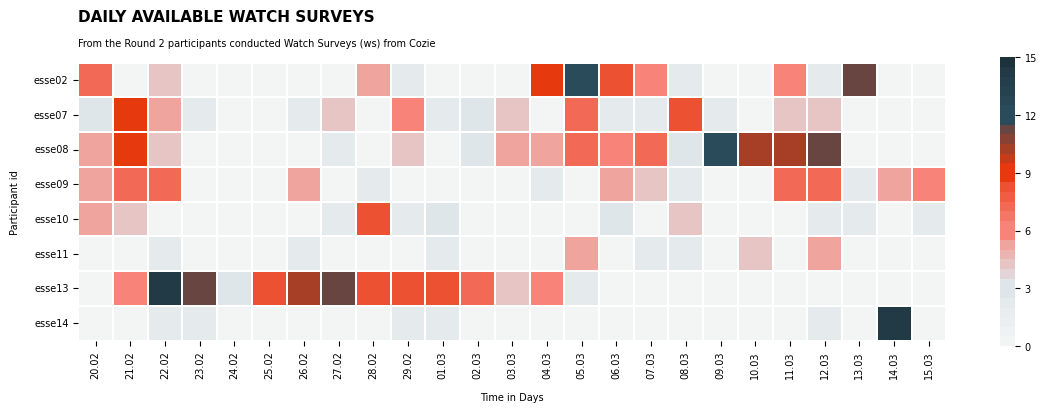

index_time,20.02,21.02,22.02,23.02,24.02,25.02,26.02,27.02,28.02,29.02,...,06.03,07.03,08.03,09.03,10.03,11.03,12.03,13.03,14.03,15.03
id_participant,,,,,,,,,,,,,,,,,,,,,
esse02,7.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,...,8.0,6.0,2.0,0.0,0.0,6.0,2.0,11.0,0.0,0.0
esse07,3.0,9.0,5.0,2.0,0.0,0.0,2.0,4.0,0.0,6.0,...,2.0,2.0,8.0,2.0,0.0,4.0,4.0,0.0,0.0,0.0
esse08,5.0,9.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,...,6.0,7.0,3.0,12.0,10.0,10.0,11.0,0.0,0.0,0.0
esse09,5.0,7.0,7.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,...,5.0,4.0,2.0,0.0,0.0,7.0,7.0,2.0,5.0,6.0
esse10,5.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,2.0,...,3.0,0.0,4.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0
esse11,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,2.0,2.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0
esse13,0.0,6.0,14.0,11.0,3.0,8.0,10.0,11.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
esse14,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,14.0,0.0


In [5]:
heatmap_df = participant_data_local_df[['index_time', 'id_participant', 'q_general_location_envi']].copy()
heatmap_df = heatmap_df[~heatmap_df['id_participant'].isin(whitelistParticipants)]

heatmap_df = heatmap_df.dropna(subset=['q_general_location_envi'])
heatmap_df = heatmap_df.set_index('index_time')

grouped_df = heatmap_df.groupby(['id_participant'])

daily_participant_counts = grouped_df['q_general_location_envi'].resample('D').count().unstack(level=1).fillna(0)

start_date = '2024-02-15'
end_date = '2024-03-15'

start_date = pd.Timestamp(start_date, tz='Asia/Singapore')
end_date = pd.Timestamp(end_date, tz='Asia/Singapore')

idx = pd.IndexSlice[:, start_date:end_date]
filtered_daily_participant_counts = daily_participant_counts.loc[idx]

filtered_daily_participant_counts.columns = filtered_daily_participant_counts.columns.strftime('%d.%m')

vmax = 15
step_size = 3
cbar_labels = ['0','3', '6', '9', '12', '15']
title = 'DAILY AVAILABLE WATCH SURVEYS'
subtitle = ('From the Round 2 participants conducted Watch Surveys (ws) from Cozie')
xlabel = 'Time in Days'
ylabel = 'Participant id'

# Call the function with appropriate arguments
_modules.StandartHeatmap(
    df=filtered_daily_participant_counts, 
    vmax=vmax, 
    step_size=step_size, 
    cmap=gradient_lightvulcanelderberry, 
    cbar_labels=cbar_labels,
    title=title, 
    subtitle=subtitle, 
    xlabel=xlabel, 
    ylabel=ylabel,
    filepath= os.path.join(filepath_dir, "Heatmap_DailyWatchSurveys_Rnd2.png")
)



Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_01-TimeSeriesData\Heatmap_DailyWatchSurveys_Rn1.png


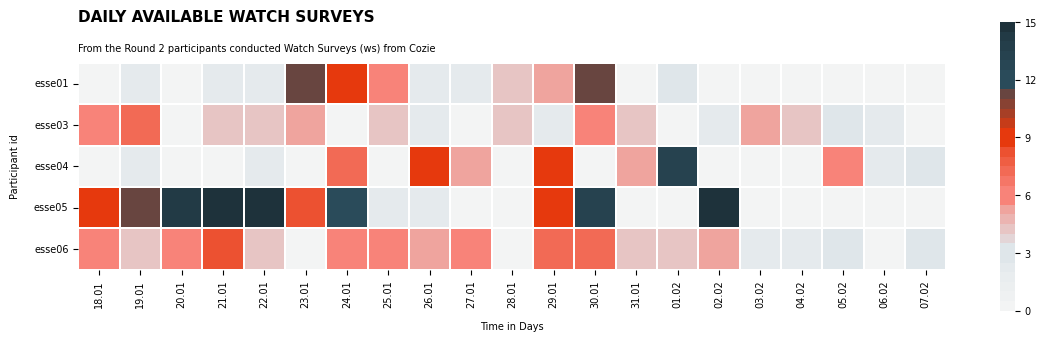

index_time,18.01,19.01,20.01,21.01,22.01,23.01,24.01,25.01,26.01,27.01,...,29.01,30.01,31.01,01.02,02.02,03.02,04.02,05.02,06.02,07.02
id_participant,,,,,,,,,,,,,,,,,,,,,
esse01,0.0,2.0,0.0,2.0,2.0,11.0,9.0,6.0,2.0,2.0,...,5.0,11.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
esse03,6.0,7.0,0.0,4.0,4.0,5.0,0.0,4.0,2.0,0.0,...,2.0,6.0,4.0,0.0,2.0,5.0,4.0,3.0,2.0,0.0
esse04,0.0,2.0,0.0,0.0,2.0,0.0,7.0,0.0,9.0,5.0,...,9.0,0.0,5.0,13.0,0.0,0.0,0.0,6.0,2.0,3.0
esse05,9.0,11.0,14.0,16.0,15.0,8.0,12.0,2.0,2.0,0.0,...,9.0,13.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
esse06,6.0,4.0,6.0,8.0,4.0,0.0,6.0,6.0,5.0,6.0,...,7.0,7.0,4.0,4.0,5.0,2.0,2.0,3.0,0.0,3.0


In [6]:
heatmap_df = participant_data_local_df[['index_time', 'id_participant', 'q_general_location_envi']].copy()
heatmap_df = heatmap_df[~heatmap_df['id_participant'].isin(whitelistParticipantsRnd1)]

heatmap_df = heatmap_df.dropna(subset=['q_general_location_envi'])
heatmap_df = heatmap_df.set_index('index_time')

grouped_df = heatmap_df.groupby(['id_participant'])

daily_participant_counts = grouped_df['q_general_location_envi'].resample('D').count().unstack(level=1).fillna(0)

start_date = '2024-01-01'
end_date = '2024-02-25'

start_date = pd.Timestamp(start_date, tz='Asia/Singapore')
end_date = pd.Timestamp(end_date, tz='Asia/Singapore')

idx = pd.IndexSlice[:, start_date:end_date]
filtered_daily_participant_counts = daily_participant_counts.loc[idx]

filtered_daily_participant_counts.columns = filtered_daily_participant_counts.columns.strftime('%d.%m')

vmax = 15
step_size = 3
cbar_labels = ['0','3', '6', '9', '12', '15']
title = 'DAILY AVAILABLE WATCH SURVEYS'
subtitle = ('From the Round 1 participants conducted Watch Surveys (ws) from Cozie')
xlabel = 'Time in Days'
ylabel = 'Participant id'

# Call the function with appropriate arguments
_modules.StandartHeatmap(
    df=filtered_daily_participant_counts, 
    vmax=vmax, 
    step_size=step_size, 
    cmap=gradient_lightvulcanelderberry, 
    cbar_labels=cbar_labels,
    title=title, 
    subtitle=subtitle, 
    xlabel=xlabel, 
    ylabel=ylabel,
    filepath= os.path.join(filepath_dir, "Heatmap_DailyWatchSurveys_Rnd1.png", )
)



### Barchart_DataAvailability_valid


In [45]:
ws_column = ['q_general_location_envi']
selected_columns = ['c_longitude', 'ts_heart_rate', 'ws_heart_rate']
combined_column = ['index_time', 'id_participant'] + ws_column + selected_columns
df = participant_data_local_df[combined_column].copy()
df = df[~df['id_participant'].isin(whitelistParticipants)]

# Calculate 'total_responses' by summing up non-null checks in the selected columns
df['total_responses'] = df[selected_columns].notnull().sum(axis=1)

# Calculate 'ws_responses' by checking non-null values in the ws_column
df['ws_responses'] = df[ws_column].notnull().sum(axis=1)

# Group by 'id_participant' and 'index_time', and sum up the responses
hourly_responses = df.groupby(['id_participant', pd.Grouper(key='index_time', freq='H')]).sum()

# Reset index to get a tidy dataframe
hourly_responses.reset_index(inplace=True)

# Select only the required columns for the final result
hourly_responses = hourly_responses[['index_time', 'id_participant', 'total_responses', 'ws_responses']]

print(hourly_responses)

                   index_time id_participant  total_responses  ws_responses
0   2024-02-20 10:00:00+08:00         esse02               57             2
1   2024-02-20 11:00:00+08:00         esse02               52             3
2   2024-02-20 20:00:00+08:00         esse02                6             0
3   2024-02-20 21:00:00+08:00         esse02               36             2
4   2024-02-22 13:00:00+08:00         esse02               39             2
..                        ...            ...              ...           ...
616 2024-03-27 10:00:00+08:00         esse14               17             2
617 2024-03-27 11:00:00+08:00         esse14                2             1
618 2024-03-27 20:00:00+08:00         esse14                1             0
619 2024-03-27 21:00:00+08:00         esse14               17             4
620 2024-03-27 22:00:00+08:00         esse14                1             1

[621 rows x 4 columns]


Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_01-TimeSeriesData\Barchart_DataAvailability_valid_Rnd2.png


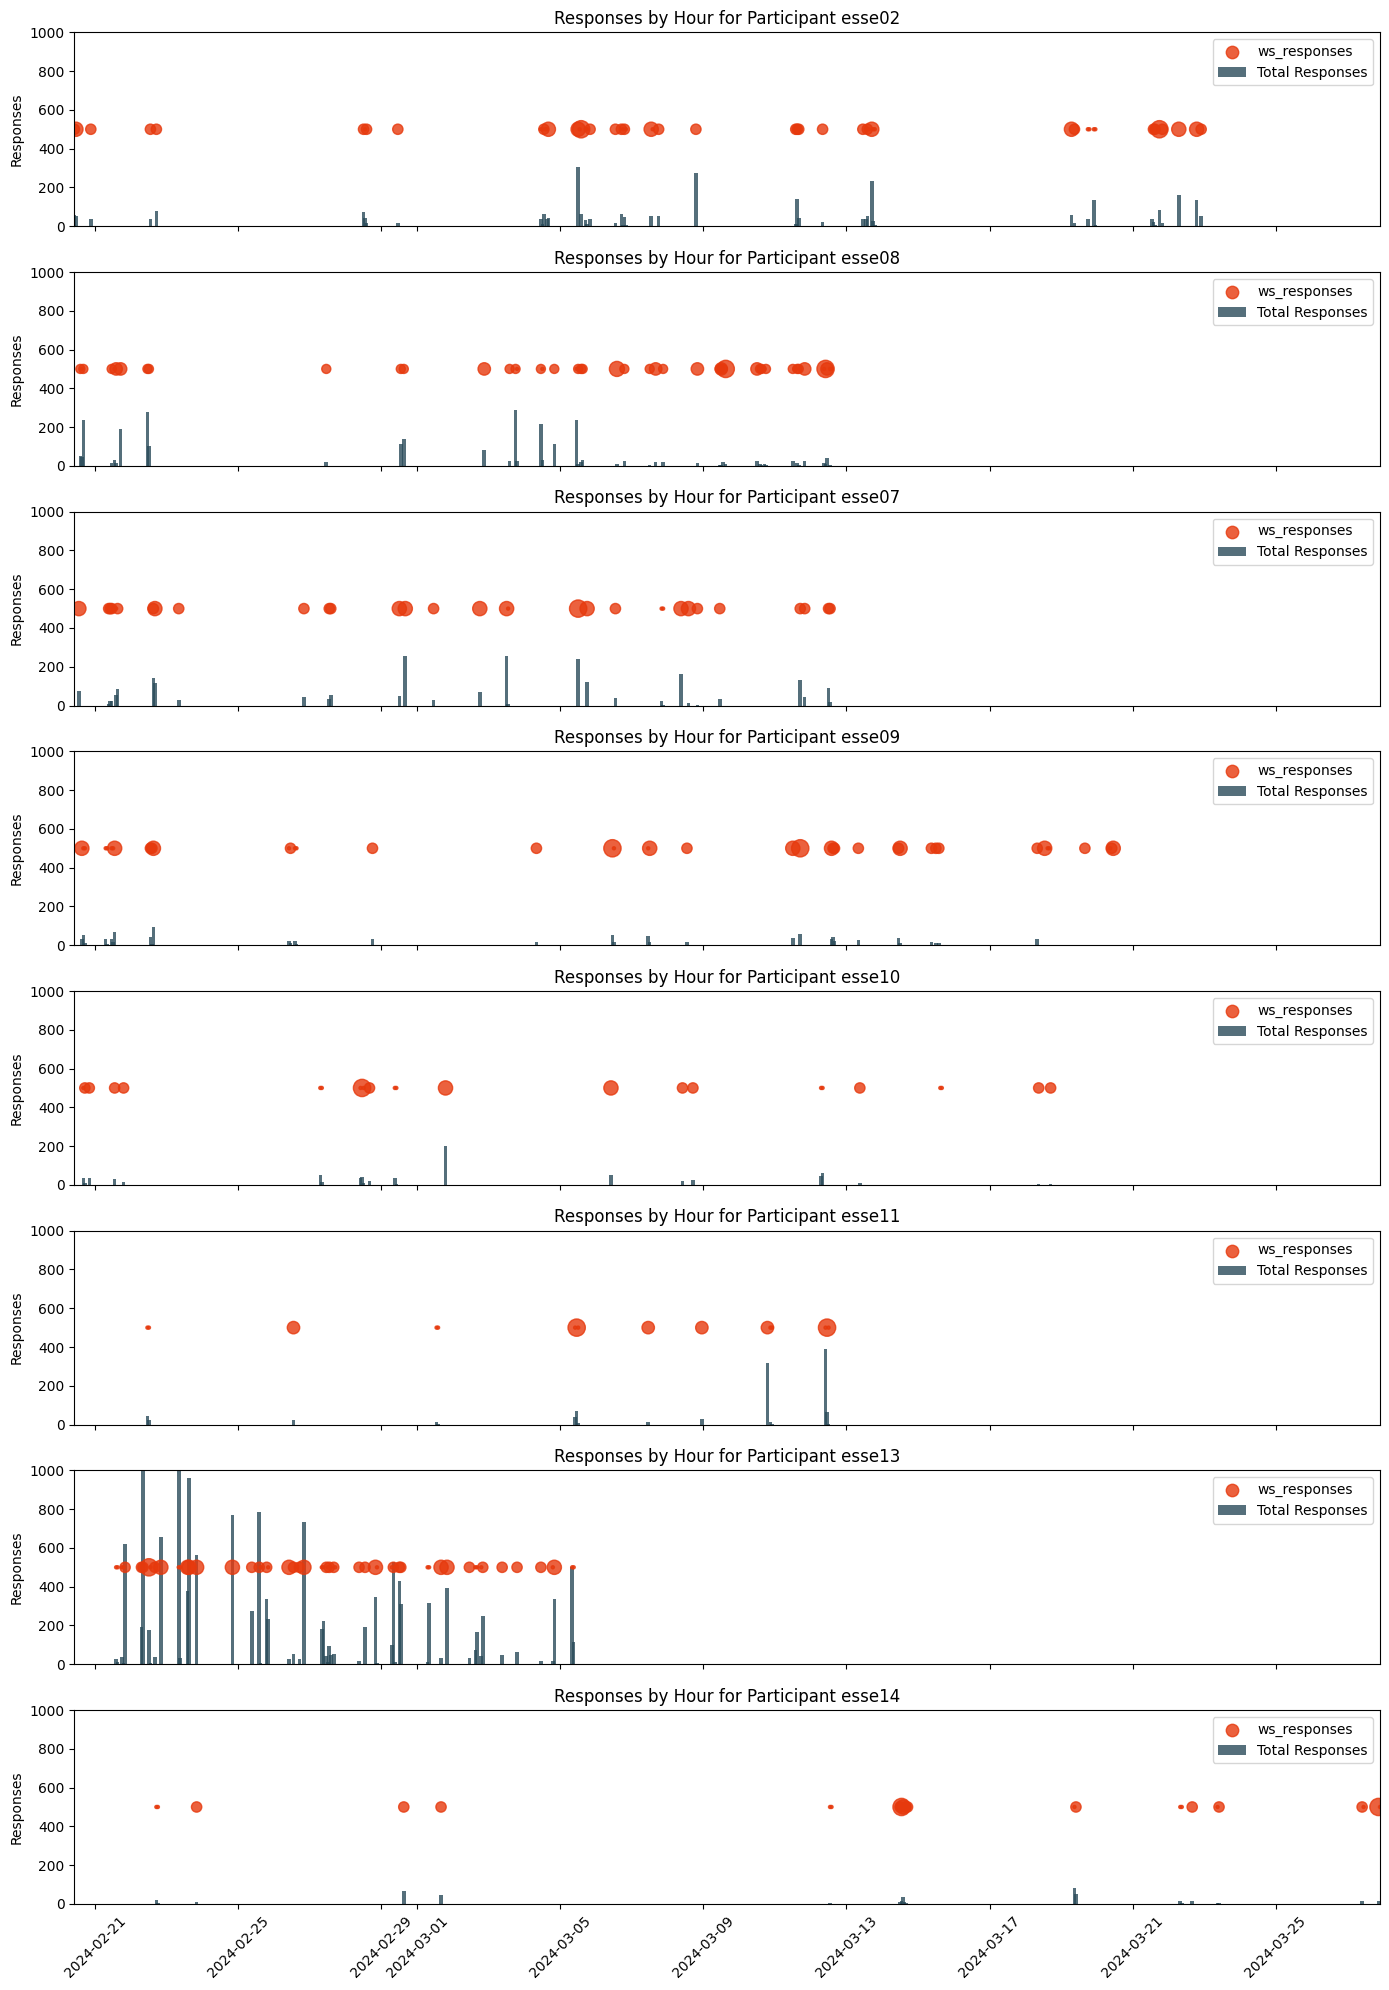

In [48]:
#TODO NOW IDEALLZ IT WOULD BE COOL TO SEE THE DIFFERENCE BETWEEN valid and not valid data.


# Sort values by 'index_time' for plotting purposes
hourly_responses.sort_values('index_time', inplace=True)

# Get the min and max index_time across all participants
min_index_time = hourly_responses['index_time'].min()
max_index_time = hourly_responses['index_time'].max()

min_x = 0
max_x = 1000

# Calculate the number of days between min and max index_time
num_days = (max_index_time - min_index_time).days + 1

# Create subplots for each participant
fig, axs = plt.subplots(len(hourly_responses['id_participant'].unique()), 1, figsize=(14, 20), sharex=True)

# Iterate over unique participant IDs
for ax, participant_id in zip(axs, hourly_responses['id_participant'].unique()):
    # Filter data for the current participant ID
    df_participant = hourly_responses[hourly_responses['id_participant'] == participant_id]
    
    # Resample to ensure all hours are present, even if they are zero
    df_participant = df_participant.set_index('index_time').resample('H').sum().fillna(0)
    
    # Filter out rows where ws_responses is zero
    df_participant = df_participant[df_participant['ws_responses'] > 0]
    
    # Calculate size for scatter points (ws_responses scaled between 5 and 100)
    if not df_participant.empty:
        df_participant['scatter_size'] = 5 + 150 * (df_participant['ws_responses'] - df_participant['ws_responses'].min()) / (df_participant['ws_responses'].max() - df_participant['ws_responses'].min())
    else:
        df_participant['scatter_size'] = 0
    
    # Plot bars for total_responses vs. index_time for the current participant
    ax.bar(df_participant.index, df_participant['total_responses'], label='Total Responses', width=0.1, align='center', color=color_deepseablue, alpha=0.8)
    
    # Scatter plot for ws_responses
    if not df_participant.empty:
        ax.scatter(df_participant.index, [500] * len(df_participant), s=df_participant['scatter_size'], color=color_vulcanfire, alpha=0.8, label='ws_responses')
    
    ax.set_ylim(min_x, max_x)
    
    # Beautify the plot
    ax.set_ylabel('Responses')
    ax.set_title(f'Responses by Hour for Participant {participant_id}')
    ax.legend()

# Set x-axis limits based on min and max index_time
plt.xlim(min_index_time, max_index_time)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()


filepath = os.path.join(filepath_dir, "Barchart_DataAvailability_valid_Rnd2.png")
directory = os.path.dirname(filepath)
if not os.path.exists(directory):
    os.makedirs(directory)
        
plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
print(f"Plot saved to {filepath}")

# Display the plot
plt.show()


 # STACKED BARCHARTS

In [ ]:
# Plot 1 details
title1 = 'OVERVIEW OF DATA TOTAL DATA RESPONSES'
subtitle1 = ('This is the subtitle, it is usually about 50 characters long and then \n'
                'a break in order to continue ')
xlabel1 = 'Participant Id'
ylabel1 = 'Total Count of datapoints'
colors1 = ['#A9A9A9', '#ADD8E6', '#FFFF00', 'Green', 'Blue']
ymax1 = 90000

# Plot 2 details
title2 = 'THIS IS A TEST'
subtitle2 = ('This is the subtitle, it is usually about 50 characters long and then \n'
                'a break in order to continue ')
xlabel2 = 'Participant Id'
ylabel2 = 'Total Count of datapoints'
colors2 = ['Yellow', "Green", "Pink", 'Green', 'Blue']
ymax2 = 90000

# Create a figure with multiple subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 16), tight_layout=True)

# Generate individual plots
_modules.TLStandardClosedStackedBarchart(axs[0], daily_participant_counts, title1, subtitle1, xlabel1, ylabel1, colors1, ymax1)
_modules.TLStandardClosedStackedBarchart(axs[1], daily_participant_counts, title2, subtitle2, xlabel2, ylabel2, colors2, ymax2)

# Show the figure with subplots
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8), tight_layout=True)

# Generate the individual plot
_modules.TLStandardClosedStackedBarchart(ax, daily_participant_counts, title1, subtitle1, xlabel1, ylabel1, colors1, ymax1)

# Show the figure
plt.show()